
Branin: 2D


In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 3.5 MB/s 
     |████████████████████████████████| 872 kB 43.2 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=b0934133f50a4254b55d230a647ec8846d10da345ef4abfd4b57afc954619a66
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=9928695284bb69bdefa047c266815123cebf7223259bbf07f847cc64ed97d2c0
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [2]:
### 1. Import python modules/packages required:

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import warnings
import itertools
import seaborn as sns
import time

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential
from joblib import Parallel, delayed
from scipy.linalg import inv
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import t
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Branin'
n_test = 500
eps = 1e-08

util = 'EI'

n_init = 5 # random initialisations
iters = 20
opt = True

df = 3

In [4]:
### Objective Function - Branin(x) 2-D:

def objfunc(x1_training, x2_training, a = 1, b = (5.1 / (4 * (np.pi) ** 2)), c = (5 / (np.pi)), r = 6, s = 10, t = (1 / (8 * np.pi))):
        return operator * ((a * (x2_training - b * x1_training ** 2 + c * x1_training - r) ** 2) + 
                 s * (1 - t) * np.cos(x1_training) + s)
        
# Constraints:
lb_x1 = -5 
ub_x1 = +10
lb_x2 = +0 
ub_x2 = +15

# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}

# True y bounds:
operator = -1
y_lb = 0.397887 # targets global minimum
y_global_orig = y_lb * operator # targets global minimum


# Test data:
x1_test = np.linspace(lb_x1, ub_x1, n_test)
x2_test = np.linspace(lb_x2, ub_x2, n_test)
  
x_test = np.column_stack((x1_test,x2_test))


In [5]:
n_start_AcqFunc = iters
inverse = -1


In [6]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dtStudentProcess(tStudentProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the STP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        
        smd_adj = (self.nu + self.beta1 - 2) / (self.nu + self.n1 - 2)

        alpha = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), self.y)
        alpha_Kstar = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)      
        
        dm = np.dot(dKstar, alpha)
        ds = -2 * smd_adj * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds 
        

In [8]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]
    
    def EI(self, tau, mean, std, ds, dm, nu=3.0):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * t.cdf(gamma, df=nu) + (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * (t.cdf(gamma, df=nu) * dmdx + gamma * t.pdf(gamma, df=nu) \
            * (1 - (nu + gamma ** 2)/(nu - 1) + 2/(nu - 1) * dmdx))
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm, nu=3.0):
    
        return self.f(tau, mean, std, ds, dm, nu=3.0, **self.params)
        

In [9]:
## GPGO_multi: 

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact EI: StdDev. x \t Approx EI: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.x_best_std)

        x_best_exact = np.empty((n_start, len(self.parameter_key)))
        f_best_exact = np.empty((n_start,))
        opt_exact = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_exact = np.array([res.x for res in opt_exact])
        f_best_exact = np.array([np.atleast_1d(res.fun)[0] for res in opt_exact])
        f_best_min_exact = min(f_best_exact)

        self.x_best_exact = x_best_exact
        self.f_best_exact = f_best_exact
        self.f_best_min_exact = f_best_min_exact
        self.x_best_std_exact = np.std(x_best_exact)
        self.best_exact = x_best_exact[np.argmin(f_best_exact)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_exact)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_exact = str(self.f_best_min_exact)
        x_best_std = str(self.x_best_std)
        x_best_std_exact = str(self.x_best_std_exact)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_exact = BOLD + OKGREEN + x_best_std_exact + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std_exact, x_best_std))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO:

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact EI: StdDev. x \t Approx EI: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_approx = np.empty((n_start, len(self.parameter_key)))
        f_best_approx = np.empty((n_start,))
        opt_approx = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_approx = np.array([res.x for res in opt_approx])
        f_best_approx = np.array([np.atleast_1d(res.fun)[0] for res in opt_approx])
        f_best_min_approx = min(f_best_approx)

        self.x_best_approx = x_best_approx
        self.f_best_approx = f_best_approx
        self.f_best_min_approx = f_best_min_approx
        self.x_best_std_approx = np.std(x_best_approx)
        self.best_approx = x_best_approx[np.argmin(f_best_approx)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_approx)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_approx = str(self.f_best_min_approx)
        x_best_std = str(self.x_best_std)
        x_best_std_approx = str(self.x_best_std_approx)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_approx = BOLD + OKGREEN + x_best_std_approx + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_approx))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_approx = time.time()
start_approx


1663153021.812445

In [13]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_grad(util), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 1.25533007 10.8048674 ]	 56.52874004692151	 27.68166689936483	    	    
init	 [-4.99828438  4.53498859]	 172.66531086516164	 27.68166689936483	    	    
init	 [-2.79866164  1.38507892]	 102.58290348816024	 27.68166689936483	    	    
init	 [-2.20609683  5.18341091]	 28.868064601155666	 27.68166689936483	    	    
init	 [0.95151211 8.08225101]	 27.68166689936483	 27.68166689936483	    	    
1	 [8.41909995 1.27566317]	 5.089934878453152	 5.089934878453152	 5.0986435978808435	 5.550612902632472
2  	 [ 8.98893195 10.45227242]	 70.52424256621515	 5.089934878453152	 5.743428588584457	 5.745909579853837
3  	 [2.95370607 0.03512223]	 6.283578446947582	 5.089934878453152	 4.923962259287665	 5.174381989450996
4  	 [-4.67712792 14.21955317]	 13.865244792739254	 5.089934878453152	 5.336922243132618	 6.4562404073642226
5  	 [ 5.31940371 15.        ]	 206.21215183096058	 5.08993487

In [14]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_grad(util), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [1.53992353 0.38889348]	 22.31361308916297	 6.692051508754487	    	    
init	 [3.24493717 6.52983589]	 19.233109967858276	 6.692051508754487	    	    
init	 [1.30551703 4.95502232]	 13.177851563387286	 6.692051508754487	    	    
init	 [-1.93027049  9.2890645 ]	 6.692051508754487	 6.692051508754487	    	    
init	 [-0.50517989  4.00240913]	 26.437522758780958	 6.692051508754487	    	    
1  	 [ 9.5587047  12.00387527]	 89.09951357262268	 6.692051508754487	 5.612142841263094	 5.935815288142359
2	 [9.59366035 1.69164323]	 1.3984593420568778	 1.3984593420568778	 5.193407534244319	 5.558824141617543
3  	 [ 3.24245232 12.67669673]	 110.25694222671481	 1.3984593420568778	 5.314129256966174	 6.040395913129957
4  	 [-5. 15.]	 17.508299515778166	 1.3984593420568778	 5.0282947008698455	 5.543013897114612
5  	 [-4.33140722  0.        ]	 241.04902164027686	 1.3984593420568778	 5.77

In [15]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_grad(util), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 3.26196854 10.62221734]	 71.68783452098575	 18.07886746449891	    	    
init	 [-0.63642892  7.66241408]	 18.07886746449891	 18.07886746449891	    	    
init	 [ 8.39420432 13.44439633]	 141.98653529865882	 18.07886746449891	    	    
init	 [-3.11622034  3.10864317]	 83.31045707266176	 18.07886746449891	    	    
init	 [-4.22799195  6.61214765]	 76.5294170688398	 18.07886746449891	    	    
1  	 [6.70472147 4.59545299]	 30.726791812855225	 18.07886746449891	 4.241477993385701	 4.241477993385701
2	 [-3.0291242 15.       ]	 9.420520400871323	 9.420520400871323	 5.397008567378645	 6.026965997277288
3	 [2.28876114 1.01944095]	 7.741857419775877	 7.741857419775877	 5.618940864036394	 6.330203234567997
4  	 [9.74523866 0.        ]	 8.496501781100147	 7.741857419775877	 5.016621994675144	 5.0225736346208345
5  	 [10.          8.34515946]	 30.48227201565198	 7.741857419775877	 

In [16]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_4= GPGO_multi(surrogate_approx_4, Acquisition_grad(util), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [9.50544759 8.20848374]	 32.51676744781521	 7.247126865776948	    	    
init	 [ 9.5902654  10.72223991]	 66.20566674364716	 7.247126865776948	    	    
init	 [5.46593237 3.24134243]	 20.90089401680587	 7.247126865776948	    	    
init	 [9.64411682 0.09345383]	 7.247126865776948	 7.247126865776948	    	    
init	 [-1.20526456  6.52187299]	 15.941376982363263	 7.247126865776948	    	    
1  	 [ 1.25164457 13.57001383]	 100.61648848019335	 7.247126865776948	 5.4717999935406	 5.85258200897411
2  	 [-4.27198795  1.64727177]	 188.41076037632916	 7.247126865776948	 6.062521919456094	 5.78607657471202
3  	 [-5. 15.]	 17.508299515778166	 7.247126865776948	 4.8678890622864035	 5.95838132553714
4  	 [3.89692632 8.49603732]	 48.388170458525444	 7.247126865776948	 5.289100120843434	 5.492878236823363
5  	 [1.24048009 0.        ]	 30.96079205960737	 7.247126865776948	 5.2892711403663

In [17]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_grad(util), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-1.67010243 13.06098459]	 25.390690545664548	 25.311309190989615	    	    
init	 [-1.89921267 13.77916362]	 25.311309190989615	 25.311309190989615	    	    
init	 [2.32616783 9.17615794]	 41.60147975414021	 25.311309190989615	    	    
init	 [6.48861785 7.77626982]	 63.81281921768236	 25.311309190989615	    	    
init	 [-0.54799248  2.81581843]	 34.966203644931994	 25.311309190989615	    	    
1	 [8.84124421 0.03321319]	 5.96108856337545	 5.96108856337545	 6.257038257405818	 6.146656705388622
2  	 [ 7.25988617 15.        ]	 204.3184758948758	 5.96108856337545	 5.986764400111081	 5.495075922249839
3  	 [-3.60216781  7.88589721]	 31.906172964981195	 5.96108856337545	 5.5924090091068015	 5.767229827184982
4  	 [-5.  0.]	 308.12909601160663	 5.96108856337545	 5.453686618780877	 5.869281499115821
5  	 [3.87798871 0.        ]	 6.021475944635039	 5.96108856337545	 5.040236246

In [18]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_grad(util), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [8.39290227 4.97969708]	 15.553860636684597	 15.31731051317483	    	    
init	 [7.31843685 0.62544939]	 15.31731051317483	 15.31731051317483	    	    
init	 [-3.3851498   8.92578096]	 16.222288919361837	 15.31731051317483	    	    
init	 [2.94726043 6.28211143]	 15.406373581304088	 15.31731051317483	    	    
init	 [0.03111774 9.33779148]	 31.07053245856209	 15.31731051317483	    	    
1  	 [ 9.64829531 12.55362889]	 98.32295673962142	 15.31731051317483	 5.281664754978231	 5.668419882807131
2  	 [-1.22578785  0.62063252]	 69.8637190838968	 15.31731051317483	 5.319959825185585	 6.326208512726862
3  	 [ 4.34724927 14.59608757]	 177.48889452505895	 15.31731051317483	 5.182963590223719	 5.423862190519217
4  	 [-5.         14.27704359]	 21.19369717678972	 15.31731051317483	 5.676094102099546	 6.403846199628598
5  	 [-5.         4.2159156]	 180.98212308506749	 15.317310513174

In [19]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_grad(util), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-3.85537566 11.69878188]	 8.299317850233932	 5.211335324193094	    	    
init	 [ 1.57613847 10.85197767]	 59.50408380701259	 5.211335324193094	    	    
init	 [9.66984268 8.07743806]	 29.714921414987273	 5.211335324193094	    	    
init	 [2.51680695 1.080767  ]	 5.211335324193094	 5.211335324193094	    	    
init	 [-0.9734153   7.49823751]	 15.431057204948033	 5.211335324193094	    	    
1  	 [-4.97859679  1.38393519]	 260.3293952774437	 5.211335324193094	 4.308091072598926	 4.425188484137239
2  	 [ 7.8077891 15.       ]	 194.07818525756468	 5.211335324193094	 5.886696598507402	 5.826057419862185
3  	 [8.45471203 0.        ]	 7.734785743805244	 5.211335324193094	 5.538378514589358	 5.287283604490958
4  	 [-3.39684884  5.54228873]	 54.79871094423047	 5.211335324193094	 4.531913841419358	 4.684343925138193
5  	 [4.60766751 5.84845649]	 28.70209781229859	 5.21133532419309

In [20]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_grad(util), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 8.10144104 14.52810994]	 175.17297136347514	 15.416245468470875	    	    
init	 [8.0379181  7.96283537]	 49.32173799887473	 15.416245468470875	    	    
init	 [-1.50907508  0.17098206]	 83.26753461673219	 15.416245468470875	    	    
init	 [1.45703227 6.0352704 ]	 15.416245468470875	 15.416245468470875	    	    
init	 [2.84012007 7.17587694]	 22.49093277852639	 15.416245468470875	    	    
1  	 [-5. 15.]	 17.508299515778166	 15.416245468470875	 5.113061507619488	 5.635856736903455
2  	 [5.86913212 0.        ]	 20.020520922399328	 15.416245468470875	 5.268522870694767	 5.4442384029503765
3  	 [-5.          5.22802787]	 155.7493784165684	 15.416245468470875	 4.98122017563304	 5.972346987777901
4  	 [ 2.32270498 12.71774943]	 97.87131718417885	 15.416245468470875	 5.833761983113529	 5.588815934752306
5	 [-2.6563415  10.30606248]	 2.200567668077322	 2.200567668077322	 5.7

In [21]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_grad(util), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-4.84438769  7.52811888]	 96.15564306553264	 3.4640248583909496	    	    
init	 [2.4365994  2.00744293]	 3.4640248583909496	 3.4640248583909496	    	    
init	 [-2.86833372  3.27838013]	 70.46930174488207	 3.4640248583909496	    	    
init	 [1.27762271 3.72151753]	 12.982825924833865	 3.4640248583909496	    	    
init	 [-3.73910523  5.1824796 ]	 75.58547400560856	 3.4640248583909496	    	    
1  	 [ 7.05609655 14.75038872]	 200.4388688685465	 3.4640248583909496	 5.707262055695117	 5.510307113917957
2  	 [-0.46054038 14.56197292]	 79.4666617606301	 3.4640248583909496	 5.22888222448805	 4.867813289580715
3  	 [10.  0.]	 10.960889035651505	 3.4640248583909496	 5.12282090032766	 4.500011981298069
4  	 [8.06986468 5.33831307]	 22.148910396007107	 3.4640248583909496	 4.965441538911707	 4.5345213701513964
5  	 [3.36572398 9.89904965]	 61.35879340637217	 3.4640248583909496	 5.

In [22]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_grad(util), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [6.56980965 0.31127924]	 19.863985024602144	 2.710610964564512	    	    
init	 [ 4.50472352 11.23205824]	 103.66999147252169	 2.710610964564512	    	    
init	 [2.47760518 3.37194968]	 2.710610964564512	 2.710610964564512	    	    
init	 [-2.02905703 11.40796068]	 8.463930835255017	 2.710610964564512	    	    
init	 [-2.46333745  1.32509721]	 90.49481266026973	 2.710610964564512	    	    
1  	 [ 9.16391068 14.81438212]	 158.2412724465548	 2.710610964564512	 4.79428467440649	 5.203917709185374
2  	 [9.65621089 6.61160737]	 16.1339423373336	 2.710610964564512	 4.468203933218896	 4.776287144468003
3  	 [-3.43070383  6.59407857]	 41.58407101130534	 2.710610964564512	 4.368505583501311	 5.002268036787654
4  	 [-5.         14.85161519]	 18.17945951420164	 2.710610964564512	 5.351324250953185	 5.578819823417572
5  	 [ 1.08260154 15.        ]	 126.2625598849657	 2.7106109645645

In [23]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_grad(util), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.29595467  0.29212862]	 104.49282729548965	 22.37435843952312	    	    
init	 [ 1.9482779  10.87400894]	 62.47758067812407	 22.37435843952312	    	    
init	 [1.30305407 7.28140647]	 22.37435843952312	 22.37435843952312	    	    
init	 [-4.80828778  7.31057411]	 97.94503054415523	 22.37435843952312	    	    
init	 [ 9.12709979 12.76192634]	 111.62900800771942	 22.37435843952312	    	    
1	 [6.94653631 0.95529646]	 17.615403152614682	 17.615403152614682	 4.572990142708335	 4.995408119136995
2	 [-3.75014886 13.17504728]	 2.494181445787241	 2.494181445787241	 4.8360421899299055	 5.502311667340213
3  	 [8.95607139 6.8918898 ]	 24.31889109179147	 2.494181445787241	 5.042262678029761	 5.2611171566648345
4  	 [2.40896631 2.4917839 ]	 3.0412848592917765	 2.494181445787241	 4.096671660714119	 4.371457434367808
5  	 [ 4.53930922 15.        ]	 192.2917148712024	 2.494181445787

In [24]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_grad(util), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.68755736 11.10074545]	 1.3827702760021356	 0.5499315281120278	    	    
init	 [-1.05027477  8.0060909 ]	 14.81231853080056	 0.5499315281120278	    	    
init	 [-4.78137556 13.78120512]	 18.401131000214548	 0.5499315281120278	    	    
init	 [8.51072281 0.50132141]	 5.855172364344769	 0.5499315281120278	    	    
init	 [9.35424004 2.05813982]	 0.5499315281120278	 0.5499315281120278	    	    
1  	 [10.          5.04089783]	 6.096345088746473	 0.5499315281120278	 4.793668138150754	 4.182314830100322
2  	 [ 5.04936449 13.86496049]	 172.12573102553992	 0.5499315281120278	 5.542199122612795	 4.479938833011862
3  	 [-4.8799499   0.15657603]	 290.0404981832191	 0.5499315281120278	 5.485318842357276	 5.103959391008001
4  	 [4.39406709 7.1625874 ]	 39.049534309848006	 0.5499315281120278	 4.728601594804281	 4.77542649896023
5  	 [3.2409573  1.35537959]	 1.1565835566493767	 0.5

In [25]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_grad(util), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [6.66553616 3.5631183 ]	 24.823670200298267	 18.038943061558626	    	    
init	 [ 7.36417799 14.48623797]	 188.7803334745195	 18.038943061558626	    	    
init	 [9.58901671 6.80173871]	 18.038943061558626	 18.038943061558626	    	    
init	 [ 4.13563694 11.63289772]	 104.87319703906111	 18.038943061558626	    	    
init	 [ 4.62420017 10.83027344]	 98.03271225790056	 18.038943061558626	    	    
1  	 [-4.93582033 12.01182521]	 37.037802784941654	 18.038943061558626	 5.522714454318587	 5.806619281166263
2  	 [-1.97548887  2.63594795]	 55.39151295488282	 18.038943061558626	 3.282905924798836	 4.615941238472937
3  	 [-0.7160137   8.30321848]	 18.448430333002875	 18.038943061558626	 5.94708646467097	 5.58238879316603
4  	 [-0.32848863 15.        ]	 90.71537376175105	 18.038943061558626	 5.670031945153216	 6.493809455554206
5	 [10.  0.]	 10.960889035651505	 10.960889035651505

In [26]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_grad(util), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 2.70915016 11.59747578]	 81.58264375064097	 1.4149920024014744	    	    
init	 [8.05641529 0.12070423]	 10.148649076616518	 1.4149920024014744	    	    
init	 [-0.35396112 14.36405609]	 79.6056658956529	 1.4149920024014744	    	    
init	 [2.69675068 4.77426637]	 5.855607664288365	 1.4149920024014744	    	    
init	 [3.08799906 3.31882414]	 1.4149920024014744	 1.4149920024014744	    	    
1  	 [-5.          5.10147552]	 158.7923570035373	 1.4149920024014744	 5.296988628673486	 5.3777635677532505
2  	 [ 9.02510452 14.92575454]	 164.15736583327134	 1.4149920024014744	 5.484348732871372	 5.667703827433153
3  	 [8.4415984  6.61360555]	 28.132050221972662	 1.4149920024014744	 5.294593167786979	 5.7314332769488265
4  	 [-0.96612544  0.60450996]	 65.21350096625167	 1.4149920024014744	 4.966846166472074	 4.101271974079413
5  	 [-2.33725825  9.62116869]	 3.987120786424799	 1.4

In [27]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_grad(util), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [7.73226546 2.68343887]	 12.768724532005583	 12.768724532005583	    	    
init	 [-4.18455179  5.42307669]	 95.39334176626551	 12.768724532005583	    	    
init	 [-0.86898607  7.95000337]	 16.419487782111716	 12.768724532005583	    	    
init	 [-0.41121626  4.56711539]	 23.250362743740954	 12.768724532005583	    	    
init	 [-3.32388086  3.74848521]	 80.99796277938532	 12.768724532005583	    	    
1  	 [ 6.5655417  11.87699252]	 134.95011349993544	 12.768724532005583	 4.778377002095066	 5.03398539056343
2  	 [-4.77493765 13.49591113]	 19.896906503438096	 12.768724532005583	 5.085559724490371	 6.068903666287861
3  	 [ 0.98442314 13.77486382]	 100.25586217994197	 12.768724532005583	 5.6313058911702205	 5.845404205066821
4	 [2.67195291 0.        ]	 8.565038534792663	 8.565038534792663	 5.045616108132687	 5.196208251192368
5  	 [10.          7.39117736]	 21.19962201935506	 8

In [28]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_grad(util), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-1.65063381  7.84745012]	 10.514702126319445	 2.715864006988424	    	    
init	 [3.26052185 0.68402925]	 2.715864006988424	 2.715864006988424	    	    
init	 [0.41093253 3.34621413]	 22.889515127492515	 2.715864006988424	    	    
init	 [5.33089243 2.45597138]	 17.178157611778595	 2.715864006988424	    	    
init	 [-3.945127  14.1151629]	 3.3649224341694195	 2.715864006988424	    	    
1  	 [ 5.63879248 14.58068289]	 198.51319639462758	 2.715864006988424	 5.294379775593306	 5.541078495643862
2  	 [10.          7.05276037]	 18.344051204785167	 2.715864006988424	 5.897176526566142	 5.489359615241944
3  	 [4.5828363 8.2591463]	 55.54199965164386	 2.715864006988424	 5.043031118903337	 5.850462250556073
4  	 [-5.          2.42332255]	 230.70055470298465	 2.715864006988424	 5.67400629716211	 6.311432336248679
5  	 [10.  0.]	 10.960889035651505	 2.715864006988424	 5.805738077

In [29]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_grad(util), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-0.58002496  7.95880133]	 19.016141117164256	 19.016141117164256	    	    
init	 [-2.1271882   1.01850537]	 85.05949339404415	 19.016141117164256	    	    
init	 [6.8047819  9.84500283]	 93.89792695202516	 19.016141117164256	    	    
init	 [4.56281344 8.63404341]	 60.50217141122736	 19.016141117164256	    	    
init	 [-4.41405626  5.36720407]	 110.70834086593878	 19.016141117164256	    	    
1	 [10.  0.]	 10.960889035651505	 10.960889035651505	 5.807197416513701	 7.182295008591052
2  	 [-0.36591853 14.49945231]	 81.3728947682288	 10.960889035651505	 5.018983318654209	 5.333386442502146
3	 [3.74599703 2.35814314]	 2.3563457989420957	 2.3563457989420957	 4.560615997629092	 4.4735542814960425
4  	 [10. 15.]	 145.87219087939556	 2.3563457989420957	 5.7151664398476925	 6.335028961794829
5  	 [-5.         11.19052106]	 48.6858321497466	 2.3563457989420957	 5.002749108235738

In [30]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_grad(util), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [4.75561363 7.58180061]	 49.215059064668324	 8.150075223157177	    	    
init	 [8.17902206 2.72760338]	 8.150075223157177	 8.150075223157177	    	    
init	 [ 7.78349603 11.25204429]	 106.98107856533271	 8.150075223157177	    	    
init	 [ 4.99152501 14.81843172]	 196.08601750690153	 8.150075223157177	    	    
init	 [-1.14547366  0.42458888]	 71.23649635555944	 8.150075223157177	    	    
1	 [-2.12483893 10.71385111]	 5.508754856016457	 5.508754856016457	 5.5853463759087845	 6.064619817525864
2  	 [-5.          4.89333935]	 163.86669716889995	 5.508754856016457	 5.548569449904449	 5.770078858541384
3  	 [10.          6.68305733]	 15.486281999178598	 5.508754856016457	 5.503506541778411	 5.081959930710506
4  	 [-5. 15.]	 17.508299515778166	 5.508754856016457	 5.906315440398488	 5.789820486279829
5  	 [4.6731611 0.       ]	 11.537832002499826	 5.508754856016457	 4.346988

In [31]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_grad(util), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-3.53699597 11.41874575]	 4.475608269502271	 4.475608269502271	    	    
init	 [-1.2959304   2.07197531]	 51.13947793770689	 4.475608269502271	    	    
init	 [-0.02830155  1.24499348]	 42.63973921760034	 4.475608269502271	    	    
init	 [ 5.07965622 12.09890697]	 131.17235664506808	 4.475608269502271	    	    
init	 [9.74112872 9.53491102]	 46.84458913925112	 4.475608269502271	    	    
1  	 [10.          1.02501879]	 5.855378662100037	 4.475608269502271	 5.4309826177999145	 5.646882254432331
2  	 [0.25794334 7.76526128]	 23.981179445905788	 4.475608269502271	 5.907150267767438	 6.2026656111107235
3  	 [5.6863731  5.02756763]	 33.15650832103417	 4.475608269502271	 5.201196531610667	 5.772131819051399
4  	 [ 0.08126453 15.        ]	 102.89963325827347	 4.475608269502271	 5.3028776583970965	 5.650427863793154
5  	 [-5.          6.21524619]	 133.11103510556254	 4.475608

In [32]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_grad(util), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 3.82196202 13.46570592]	 138.5264349938869	 14.042667401507376	    	    
init	 [ 8.37296094 12.23756216]	 115.63178540512689	 14.042667401507376	    	    
init	 [-4.46165622 10.37636373]	 35.66708529307584	 14.042667401507376	    	    
init	 [0.68021413 7.77766418]	 25.307769914281764	 14.042667401507376	    	    
init	 [4.86927198 2.90775327]	 14.042667401507376	 14.042667401507376	    	    
1  	 [-0.97507528  0.42046139]	 68.01185816790611	 14.042667401507376	 4.86513489386243	 5.379503104088616
2	 [9.55649441 0.        ]	 7.180601122141473	 7.180601122141473	 5.111310165456103	 5.637762478346462
3  	 [10.          6.22944194]	 12.353348258843747	 7.180601122141473	 6.20083665806108	 5.080314802195392
4  	 [-2.88342188 15.        ]	 11.850587930117221	 7.180601122141473	 5.977470564620189	 6.74132648485286
5  	 [-4.87189328  4.58452532]	 161.23432488517537	 7.180601

In [33]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1663154450.1025848

In [34]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_grad(util), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 1.25533007 10.8048674 ]	 56.52874004692151	 27.68166689936483	    	    
init	 [-4.99828438  4.53498859]	 172.66531086516164	 27.68166689936483	    	    
init	 [-2.79866164  1.38507892]	 102.58290348816024	 27.68166689936483	    	    
init	 [-2.20609683  5.18341091]	 28.868064601155666	 27.68166689936483	    	    
init	 [0.95151211 8.08225101]	 27.68166689936483	 27.68166689936483	    	    
1	 [8.41909995 1.27566317]	 5.089934878453152	 5.089934878453152	 5.0986435978808435	 5.550612902632472
2  	 [10. 15.]	 145.87219087939556	 5.089934878453152	 5.743428588584457	 5.745909579853837
3  	 [9.50914495 8.52150693]	 36.125759150808236	 5.089934878453152	 5.17493292436728	 5.44868771731227
4  	 [-4.67712792 14.21955317]	 13.865244792739254	 5.089934878453152	 5.297127294685952	 5.896806957798368
5  	 [4.42114297 4.28364423]	 15.05485122373766	 5.089934878453152	 4.362329371

In [35]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_grad(util), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [1.53992353 0.38889348]	 22.31361308916297	 6.692051508754487	    	    
init	 [3.24493717 6.52983589]	 19.233109967858276	 6.692051508754487	    	    
init	 [1.30551703 4.95502232]	 13.177851563387286	 6.692051508754487	    	    
init	 [-1.93027049  9.2890645 ]	 6.692051508754487	 6.692051508754487	    	    
init	 [-0.50517989  4.00240913]	 26.437522758780958	 6.692051508754487	    	    
1  	 [ 9.5587047  12.00387527]	 89.09951357262268	 6.692051508754487	 5.612142841263094	 5.935815288142359
2	 [9.59366035 1.69164323]	 1.3984593420568778	 1.3984593420568778	 5.193407534244319	 5.558824141617543
3  	 [ 3.24245232 12.67669673]	 110.25694222671481	 1.3984593420568778	 5.314129256966174	 6.040395913129957
4  	 [-5.  0.]	 308.12909601160663	 1.3984593420568778	 5.0282947008698455	 5.543013897114612
5  	 [7.9643039  7.11507193]	 40.26323229404025	 1.3984593420568778	 5.35798

In [36]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_grad(util), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 3.26196854 10.62221734]	 71.68783452098575	 18.07886746449891	    	    
init	 [-0.63642892  7.66241408]	 18.07886746449891	 18.07886746449891	    	    
init	 [ 8.39420432 13.44439633]	 141.98653529865882	 18.07886746449891	    	    
init	 [-3.11622034  3.10864317]	 83.31045707266176	 18.07886746449891	    	    
init	 [-4.22799195  6.61214765]	 76.5294170688398	 18.07886746449891	    	    
1  	 [6.70472147 4.59545299]	 30.726791812855225	 18.07886746449891	 4.241477993385701	 4.241477993385701
2	 [-3.89564496 13.38589781]	 3.6010193697779265	 3.6010193697779265	 5.397008567378645	 6.026965997277288
3  	 [2.09735732 4.16564816]	 6.049352404635327	 3.6010193697779265	 5.662870973819743	 6.6516714448187795
4  	 [6.0924896 0.       ]	 20.635034297790384	 3.6010193697779265	 4.87913739953211	 5.031647917597796
5  	 [7.38322622 8.90437688]	 72.31345729730506	 3.6010193697779

In [37]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_grad(util), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [9.50544759 8.20848374]	 32.51676744781521	 7.247126865776948	    	    
init	 [ 9.5902654  10.72223991]	 66.20566674364716	 7.247126865776948	    	    
init	 [5.46593237 3.24134243]	 20.90089401680587	 7.247126865776948	    	    
init	 [9.64411682 0.09345383]	 7.247126865776948	 7.247126865776948	    	    
init	 [-1.20526456  6.52187299]	 15.941376982363263	 7.247126865776948	    	    
1  	 [ 1.25164457 13.57001383]	 100.61648848019335	 7.247126865776948	 5.4717999935406	 5.85258200897411
2  	 [-4.27198795  1.64727177]	 188.41076037632916	 7.247126865776948	 6.062521919456094	 5.78607657471202
3  	 [4.00915917 8.47937128]	 49.809284714246935	 7.247126865776948	 4.8678890622864035	 5.95838132553714
4  	 [-4.84138409  8.44878365]	 79.86770526646004	 7.247126865776948	 5.070702113839586	 6.751751223487513
5  	 [1.74626501 0.        ]	 21.389627350637003	 7.247126865776948	

In [38]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_grad(util), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-1.67010243 13.06098459]	 25.390690545664548	 25.311309190989615	    	    
init	 [-1.89921267 13.77916362]	 25.311309190989615	 25.311309190989615	    	    
init	 [2.32616783 9.17615794]	 41.60147975414021	 25.311309190989615	    	    
init	 [6.48861785 7.77626982]	 63.81281921768236	 25.311309190989615	    	    
init	 [-0.54799248  2.81581843]	 34.966203644931994	 25.311309190989615	    	    
1	 [8.84124421 0.03321319]	 5.96108856337545	 5.96108856337545	 6.257038257405818	 6.146656705388622
2  	 [ 8.50288449 15.        ]	 178.24846487856252	 5.96108856337545	 5.986764400111081	 5.495075922249839
3  	 [-5.          6.43765017]	 128.28001516361476	 5.96108856337545	 5.441055215499201	 5.764257836088027
4  	 [-5.  0.]	 308.12909601160663	 5.96108856337545	 5.111166957542164	 5.526973695448354
5  	 [4.1379882  3.47946366]	 8.217428035421637	 5.96108856337545	 4.826058832

In [39]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_grad(util), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [8.39290227 4.97969708]	 15.553860636684597	 15.31731051317483	    	    
init	 [7.31843685 0.62544939]	 15.31731051317483	 15.31731051317483	    	    
init	 [-3.3851498   8.92578096]	 16.222288919361837	 15.31731051317483	    	    
init	 [2.94726043 6.28211143]	 15.406373581304088	 15.31731051317483	    	    
init	 [0.03111774 9.33779148]	 31.07053245856209	 15.31731051317483	    	    
1  	 [-3.07553743  0.        ]	 147.23608569115513	 15.31731051317483	 5.281664754978231	 5.668419882807131
2  	 [ 9.0758891  11.79008788]	 93.01466310382783	 15.31731051317483	 5.350533916982397	 5.824233867342463
3  	 [ 4.34724927 14.59608757]	 177.48889452505895	 15.31731051317483	 5.34691430221382	 5.4303256668287005
4  	 [-1.77014503 13.95364881]	 30.486400153319025	 15.31731051317483	 5.665147917410167	 6.447813877442302
5	 [1.61545077 1.8313572 ]	 13.314442924245594	 13.31444292424

In [40]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_grad(util), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-3.85537566 11.69878188]	 8.299317850233932	 5.211335324193094	    	    
init	 [ 1.57613847 10.85197767]	 59.50408380701259	 5.211335324193094	    	    
init	 [9.66984268 8.07743806]	 29.714921414987273	 5.211335324193094	    	    
init	 [2.51680695 1.080767  ]	 5.211335324193094	 5.211335324193094	    	    
init	 [-0.9734153   7.49823751]	 15.431057204948033	 5.211335324193094	    	    
1  	 [-5.          0.17211502]	 302.2423139726426	 5.211335324193094	 4.308091072598926	 4.425188484137239
2  	 [10. 15.]	 145.87219087939556	 5.211335324193094	 5.9418263678602115	 5.778953899758212
3  	 [8.08940775 0.35854539]	 9.249625108410735	 5.211335324193094	 5.058600441564939	 5.962417830876022
4  	 [-3.39684884  5.54228873]	 54.79871094423047	 5.211335324193094	 4.531859875930617	 4.47443187301265
5  	 [5.17359234 5.7353307 ]	 34.62771248981179	 5.211335324193094	 4.828048585

In [41]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_grad(util), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 8.10144104 14.52810994]	 175.17297136347514	 15.416245468470875	    	    
init	 [8.0379181  7.96283537]	 49.32173799887473	 15.416245468470875	    	    
init	 [-1.50907508  0.17098206]	 83.26753461673219	 15.416245468470875	    	    
init	 [1.45703227 6.0352704 ]	 15.416245468470875	 15.416245468470875	    	    
init	 [2.84012007 7.17587694]	 22.49093277852639	 15.416245468470875	    	    
1	 [9.77124156 0.43098073]	 6.499298445992174	 6.499298445992174	 5.113061507619488	 5.635856736903455
2  	 [-4.87537438 11.82874897]	 36.57081146531108	 6.499298445992174	 5.657687468643916	 5.464221186524835
3  	 [-0.47864575 14.6326007 ]	 80.00768934620143	 6.499298445992174	 4.725750952759138	 5.9382287845275705
4  	 [-3.44158579  5.39867053]	 58.72225773742389	 6.499298445992174	 5.65358168566078	 5.322030721767772
5	 [3.66376848 0.        ]	 5.298915302985195	 5.29891530298519

In [42]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_grad(util), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-4.84438769  7.52811888]	 96.15564306553264	 3.4640248583909496	    	    
init	 [2.4365994  2.00744293]	 3.4640248583909496	 3.4640248583909496	    	    
init	 [-2.86833372  3.27838013]	 70.46930174488207	 3.4640248583909496	    	    
init	 [1.27762271 3.72151753]	 12.982825924833865	 3.4640248583909496	    	    
init	 [-3.73910523  5.1824796 ]	 75.58547400560856	 3.4640248583909496	    	    
1  	 [ 7.05609655 14.75038872]	 200.4388688685465	 3.4640248583909496	 5.707262055695117	 5.510307113917957
2  	 [-0.46054038 14.56197292]	 79.4666617606301	 3.4640248583909496	 5.22888222448805	 4.867813289580715
3  	 [8.28747407 1.2035024 ]	 6.196385269800155	 3.4640248583909496	 5.12282090032766	 4.500011981298069
4  	 [3.94155975 9.34962016]	 61.310487913157274	 3.4640248583909496	 5.164926280343697	 4.672953318528358
5  	 [9.67993735 5.53971063]	 8.780439004073106	 3.46402485

In [43]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_grad(util), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [6.56980965 0.31127924]	 19.863985024602144	 2.710610964564512	    	    
init	 [ 4.50472352 11.23205824]	 103.66999147252169	 2.710610964564512	    	    
init	 [2.47760518 3.37194968]	 2.710610964564512	 2.710610964564512	    	    
init	 [-2.02905703 11.40796068]	 8.463930835255017	 2.710610964564512	    	    
init	 [-2.46333745  1.32509721]	 90.49481266026973	 2.710610964564512	    	    
1  	 [ 9.16391068 14.81438212]	 158.2412724465548	 2.710610964564512	 4.79428467440649	 5.203917709185374
2  	 [9.65621089 6.61160737]	 16.1339423373336	 2.710610964564512	 4.468203933218896	 4.776287144468003
3  	 [-3.43070383  6.59407857]	 41.58407101130534	 2.710610964564512	 4.368505583501311	 5.002268036787654
4  	 [1.05948815 8.11037376]	 28.032600849082318	 2.710610964564512	 5.351324250953185	 5.578819823417572
5  	 [-4.09924692 14.83375461]	 4.493827434732684	 2.71061096456451

In [44]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_grad(util), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.29595467  0.29212862]	 104.49282729548965	 22.37435843952312	    	    
init	 [ 1.9482779  10.87400894]	 62.47758067812407	 22.37435843952312	    	    
init	 [1.30305407 7.28140647]	 22.37435843952312	 22.37435843952312	    	    
init	 [-4.80828778  7.31057411]	 97.94503054415523	 22.37435843952312	    	    
init	 [ 9.12709979 12.76192634]	 111.62900800771942	 22.37435843952312	    	    
1	 [6.94653631 0.95529646]	 17.615403152614682	 17.615403152614682	 4.572990142708335	 4.995408119136995
2  	 [6.18693254 5.95578131]	 43.15441398245177	 17.615403152614682	 4.8360421899299055	 5.502311667340213
3	 [1.17950507 2.99234971]	 15.378531253008628	 15.378531253008628	 5.174667263831869	 5.96329043419755
4  	 [ 4.90430653 15.        ]	 199.47416982917684	 15.378531253008628	 4.4325112144584455	 4.864992243667537
5	 [-3.42208896 11.32925449]	 3.4300860679630905	 3.4300860679

In [45]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_grad(util), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.68755736 11.10074545]	 1.3827702760021356	 0.5499315281120278	    	    
init	 [-1.05027477  8.0060909 ]	 14.81231853080056	 0.5499315281120278	    	    
init	 [-4.78137556 13.78120512]	 18.401131000214548	 0.5499315281120278	    	    
init	 [8.51072281 0.50132141]	 5.855172364344769	 0.5499315281120278	    	    
init	 [9.35424004 2.05813982]	 0.5499315281120278	 0.5499315281120278	    	    
1  	 [9.43895355 6.28875405]	 14.852312468115107	 0.5499315281120278	 4.793668138150754	 4.182314830100322
2  	 [-5.  0.]	 308.12909601160663	 0.5499315281120278	 5.672602160834171	 4.481227689145763
3  	 [10. 15.]	 145.87219087939556	 0.5499315281120278	 5.333641084854815	 4.944965969221232
4  	 [ 2.96504557 14.18967184]	 139.14981054237984	 0.5499315281120278	 4.419922516669865	 4.13970888109774
5  	 [1.83254566 0.        ]	 19.886256227164537	 0.5499315281120278	 4.15934588330

In [46]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_grad(util), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [6.66553616 3.5631183 ]	 24.823670200298267	 18.038943061558626	    	    
init	 [ 7.36417799 14.48623797]	 188.7803334745195	 18.038943061558626	    	    
init	 [9.58901671 6.80173871]	 18.038943061558626	 18.038943061558626	    	    
init	 [ 4.13563694 11.63289772]	 104.87319703906111	 18.038943061558626	    	    
init	 [ 4.62420017 10.83027344]	 98.03271225790056	 18.038943061558626	    	    
1  	 [-3.51870171  3.68338658]	 91.63196166423945	 18.038943061558626	 5.522714454318587	 5.806619281166263
2	 [-3.06562888 11.40851515]	 0.8943531028899869	 0.8943531028899869	 3.8217538237112976	 5.154859902035678
3  	 [1.71859813 0.        ]	 21.88162227587915	 0.8943531028899869	 5.8467888976871745	 5.679229540913796
4  	 [2.11702107 5.4034413 ]	 9.824834872557432	 0.8943531028899869	 5.848084224045363	 6.1617598247170005
5  	 [-0.27482781  8.99283113]	 25.722208565875633	 0.

In [47]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_grad(util), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 2.70915016 11.59747578]	 81.58264375064097	 1.4149920024014744	    	    
init	 [8.05641529 0.12070423]	 10.148649076616518	 1.4149920024014744	    	    
init	 [-0.35396112 14.36405609]	 79.6056658956529	 1.4149920024014744	    	    
init	 [2.69675068 4.77426637]	 5.855607664288365	 1.4149920024014744	    	    
init	 [3.08799906 3.31882414]	 1.4149920024014744	 1.4149920024014744	    	    
1  	 [-5.  0.]	 308.12909601160663	 1.4149920024014744	 5.296988628673486	 5.3777635677532505
2  	 [-3.61083748  7.85924032]	 32.481990179851884	 1.4149920024014744	 5.320604150836499	 5.707339486968772
3  	 [10. 15.]	 145.87219087939556	 1.4149920024014744	 5.315487723813065	 5.121028404681541
4  	 [8.19772537 6.72053896]	 32.63212233587686	 1.4149920024014744	 4.1727215091261565	 4.20315828389491
5  	 [0.97475301 0.        ]	 36.28784219036623	 1.4149920024014744	 4.969559308771885

In [48]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_grad(util), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [7.73226546 2.68343887]	 12.768724532005583	 12.768724532005583	    	    
init	 [-4.18455179  5.42307669]	 95.39334176626551	 12.768724532005583	    	    
init	 [-0.86898607  7.95000337]	 16.419487782111716	 12.768724532005583	    	    
init	 [-0.41121626  4.56711539]	 23.250362743740954	 12.768724532005583	    	    
init	 [-3.32388086  3.74848521]	 80.99796277938532	 12.768724532005583	    	    
1  	 [ 6.5655417  11.87699252]	 134.95011349993544	 12.768724532005583	 4.778377002095066	 5.03398539056343
2  	 [-4.77493765 13.49591113]	 19.896906503438096	 12.768724532005583	 5.085559724490371	 6.068903666287861
3	 [3.71891505 0.        ]	 5.442908441895087	 5.442908441895087	 5.6313058911702205	 5.845404205066821
4  	 [4.35176896 6.82771086]	 34.77911378970321	 5.442908441895087	 4.919083295754282	 5.025030871200043
5  	 [10. 15.]	 145.87219087939556	 5.442908441895087	 6

In [49]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_grad(util), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-1.65063381  7.84745012]	 10.514702126319445	 2.715864006988424	    	    
init	 [3.26052185 0.68402925]	 2.715864006988424	 2.715864006988424	    	    
init	 [0.41093253 3.34621413]	 22.889515127492515	 2.715864006988424	    	    
init	 [5.33089243 2.45597138]	 17.178157611778595	 2.715864006988424	    	    
init	 [-3.945127  14.1151629]	 3.3649224341694195	 2.715864006988424	    	    
1  	 [ 5.63879248 14.58068289]	 198.51319639462758	 2.715864006988424	 5.294379775593306	 5.541078495643862
2  	 [-5.  0.]	 308.12909601160663	 2.715864006988424	 5.897176526566142	 5.489359615241944
3  	 [4.39600939 7.43435868]	 42.22899400142327	 2.715864006988424	 4.851081289072472	 5.771335824801749
4  	 [10.          9.09483127]	 39.05407754897555	 2.715864006988424	 5.115270113679681	 6.0123333254996565
5  	 [ 0.8310123  11.57226008]	 62.78985808204933	 2.715864006988424	 5.2750038

In [50]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_grad(util), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-0.58002496  7.95880133]	 19.016141117164256	 19.016141117164256	    	    
init	 [-2.1271882   1.01850537]	 85.05949339404415	 19.016141117164256	    	    
init	 [6.8047819  9.84500283]	 93.89792695202516	 19.016141117164256	    	    
init	 [4.56281344 8.63404341]	 60.50217141122736	 19.016141117164256	    	    
init	 [-4.41405626  5.36720407]	 110.70834086593878	 19.016141117164256	    	    
1	 [9.76575296 0.98553483]	 4.1623278326263815	 4.1623278326263815	 5.807197416513701	 7.182295008591052
2  	 [-0.36591853 14.49945231]	 81.3728947682288	 4.1623278326263815	 4.9748975540247695	 5.3644262398357085
3	 [3.74599703 2.35814314]	 2.3563457989420957	 2.3563457989420957	 4.486543565927281	 4.517351572696088
4  	 [10. 15.]	 145.87219087939556	 2.3563457989420957	 5.680552314402931	 6.419994285155655
5  	 [9.29977095 5.44257151]	 9.903848503973805	 2.3563457989420957	 5.00

In [51]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_grad(util), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [4.75561363 7.58180061]	 49.215059064668324	 8.150075223157177	    	    
init	 [8.17902206 2.72760338]	 8.150075223157177	 8.150075223157177	    	    
init	 [ 7.78349603 11.25204429]	 106.98107856533271	 8.150075223157177	    	    
init	 [ 4.99152501 14.81843172]	 196.08601750690153	 8.150075223157177	    	    
init	 [-1.14547366  0.42458888]	 71.23649635555944	 8.150075223157177	    	    
1	 [-2.12483893 10.71385111]	 5.508754856016457	 5.508754856016457	 5.5853463759087845	 6.064619817525864
2  	 [-5.          5.56398299]	 147.82664666642734	 5.508754856016457	 5.548569449904449	 5.770078858541384
3  	 [0.88788193 4.41747816]	 16.133054615947543	 5.508754856016457	 5.485987837484299	 5.090623466113305
4  	 [4.23250225 0.        ]	 8.056944065342153	 5.508754856016457	 5.78208838858246	 6.007656712351842
5  	 [8.48364674 7.50515098]	 36.945014181400296	 5.5087548560164

In [52]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_grad(util), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-3.53699597 11.41874575]	 4.475608269502271	 4.475608269502271	    	    
init	 [-1.2959304   2.07197531]	 51.13947793770689	 4.475608269502271	    	    
init	 [-0.02830155  1.24499348]	 42.63973921760034	 4.475608269502271	    	    
init	 [ 5.07965622 12.09890697]	 131.17235664506808	 4.475608269502271	    	    
init	 [9.74112872 9.53491102]	 46.84458913925112	 4.475608269502271	    	    
1	 [9.57054653 2.03489665]	 0.8198597583535783	 0.8198597583535783	 5.4309826177999145	 5.646882254432331
2  	 [4.87196034 4.4884797 ]	 21.613480273508134	 0.8198597583535783	 5.927250970224576	 6.165904572883813
3  	 [-5.          6.16161367]	 134.29083579801522	 0.8198597583535783	 5.214311829208944	 5.762058499382029
4  	 [0.14723717 7.18515855]	 21.505239166131638	 0.8198597583535783	 5.504901969321676	 5.70719626639767
5  	 [10. 15.]	 145.87219087933477	 0.8198597583535783	 5.012

In [53]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_grad(util), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 3.82196202 13.46570592]	 138.5264349938869	 14.042667401507376	    	    
init	 [ 8.37296094 12.23756216]	 115.63178540512689	 14.042667401507376	    	    
init	 [-4.46165622 10.37636373]	 35.66708529307584	 14.042667401507376	    	    
init	 [0.68021413 7.77766418]	 25.307769914281764	 14.042667401507376	    	    
init	 [4.86927198 2.90775327]	 14.042667401507376	 14.042667401507376	    	    
1  	 [-5.          1.08303276]	 272.0731082659908	 14.042667401507376	 4.86513489386243	 5.379503104088616
2	 [9.44011208 1.98991869]	 0.6470663908351462	 0.6470663908351462	 4.803815949230901	 5.154784943280879
3  	 [0.27791048 0.        ]	 50.23262742833977	 0.6470663908351462	 4.922365406528885	 4.472371512780875
4  	 [-0.52595056 12.3818394 ]	 48.653744029890824	 0.6470663908351462	 5.831441976443628	 6.673799693838109
5  	 [7.46907551 7.13784307]	 47.45931649234844	 0.647066

In [54]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact


1356.041904449463

In [55]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(-approx_1.GP.y[0:n_init]),-approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(-exact_1.GP.y[0:n_init]),-exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(approx_output_1 - y_global_orig)
regret_exact_1 = np.log(exact_output_1 - y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(1.7025314333467774, 1.7025314333467774)

In [56]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(-approx_2.GP.y[0:n_init]),-approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(-exact_2.GP.y[0:n_init]),-exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(approx_output_2 - y_global_orig)
regret_exact_2 = np.log(exact_output_2 - y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(0.5857547920775205, 0.5857547920775205)

In [57]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(-approx_3.GP.y[0:n_init]),-approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(-exact_3.GP.y[0:n_init]),-exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(approx_output_3 - y_global_orig)
regret_exact_3 = np.log(exact_output_3 - y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(0.924276466981536, 0.5703547077649286)

In [58]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(-approx_4.GP.y[0:n_init]),-approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(-exact_4.GP.y[0:n_init]),-exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(approx_output_4 - y_global_orig)
regret_exact_4 = np.log(exact_output_4 - y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(1.1875834070733835, 0.8234348935346586)

In [59]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(-approx_5.GP.y[0:n_init]),-approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(-exact_5.GP.y[0:n_init]),-exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(approx_output_5 - y_global_orig)
regret_exact_5 = np.log(exact_output_5 - y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(1.41624935918396, 1.8498672894371022)

In [60]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(-approx_6.GP.y[0:n_init]),-approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(-exact_6.GP.y[0:n_init]),-exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(approx_output_6 - y_global_orig)
regret_exact_6 = np.log(exact_output_6 - y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(-0.01942794879848556, -0.0027052881120407093)

In [61]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(-approx_7.GP.y[0:n_init]),-approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(-exact_7.GP.y[0:n_init]),-exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(approx_output_7 - y_global_orig)
regret_exact_7 = np.log(exact_output_7 - y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(1.0446357648801028, 1.0591773722126083)

In [62]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(-approx_8.GP.y[0:n_init]),-approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(-exact_8.GP.y[0:n_init]),-exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(approx_output_8 - y_global_orig)
regret_exact_8 = np.log(exact_output_8 - y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(0.850882830640915, 1.43447535654887)

In [63]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(-approx_9.GP.y[0:n_init]),-approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(-exact_9.GP.y[0:n_init]),-exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(approx_output_9 - y_global_orig)
regret_exact_9 = np.log(exact_output_9 - y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(1.3511623609574142, 1.3440508341698283)

In [64]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(-approx_10.GP.y[0:n_init]),-approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(-exact_10.GP.y[0:n_init]),-exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(approx_output_10 - y_global_orig)
regret_exact_10 = np.log(exact_output_10 - y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(0.9665371537509266, 1.134139639930358)

In [65]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(-approx_11.GP.y[0:n_init]),-approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(-exact_11.GP.y[0:n_init]),-exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(approx_output_11 - y_global_orig)
regret_exact_11 = np.log(exact_output_11 - y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(0.8529388835998049, -0.03899851966073436)

In [66]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(-approx_12.GP.y[0:n_init]),-approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(-exact_12.GP.y[0:n_init]),-exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(approx_output_12 - y_global_orig)
regret_exact_12 = np.log(exact_output_12 - y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(-0.05359222109358334, -0.05359222109358334)

In [67]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(-approx_13.GP.y[0:n_init]),-approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(-exact_13.GP.y[0:n_init]),-exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(approx_output_13 - y_global_orig)
regret_exact_13 = np.log(exact_output_13 - y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(0.8126641951259417, 0.19470589651587628)

In [68]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(-approx_14.GP.y[0:n_init]),-approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(-exact_14.GP.y[0:n_init]),-exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(approx_output_14 - y_global_orig)
regret_exact_14 = np.log(exact_output_14 - y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(0.5949161906605641, 0.5949161906605641)

In [69]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(-approx_15.GP.y[0:n_init]),-approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(-exact_15.GP.y[0:n_init]),-exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(approx_output_15 - y_global_orig)
regret_exact_15 = np.log(exact_output_15 - y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(1.3619434758458895, 1.6001418455893557)

In [70]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(-approx_16.GP.y[0:n_init]),-approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(-exact_16.GP.y[0:n_init]),-exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(approx_output_16 - y_global_orig)
regret_exact_16 = np.log(exact_output_16 - y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(1.0908899092030067, 1.1358281109947383)

In [71]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(-approx_17.GP.y[0:n_init]),-approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(-exact_17.GP.y[0:n_init]),-exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(approx_output_17 - y_global_orig)
regret_exact_17 = np.log(exact_output_17 - y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(1.0131389279401821, 1.0131389279401821)

In [72]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(-approx_18.GP.y[0:n_init]),-approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(-exact_18.GP.y[0:n_init]),-exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(approx_output_18 - y_global_orig)
regret_exact_18 = np.log(exact_output_18 - y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(1.6241673420054983, 1.3399471357149502)

In [73]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(-approx_19.GP.y[0:n_init]),-approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(-exact_19.GP.y[0:n_init]),-exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(approx_output_19 - y_global_orig)
regret_exact_19 = np.log(exact_output_19 - y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(-0.014063413080890506, 0.1970022317043208)

In [74]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(-approx_20.GP.y[0:n_init]),-approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(-exact_20.GP.y[0:n_init]),-exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(approx_output_20 - y_global_orig)
regret_exact_20 = np.log(exact_output_20 - y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(1.9260958052164145, 0.043972282350441774)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [97]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

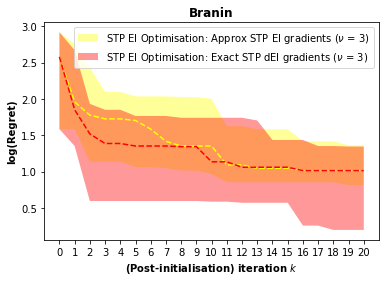

In [98]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Yellow', ls='--')
plt.plot(median_exact, color = 'Red', ls='--')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='STP EI Optimisation: Approx STP EI gradients ' r'($\nu$' ' = {})'.format(df))
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='STP EI Optimisation: Exact STP dEI gradients ' r'($\nu$' ' = {})'.format(df))

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualise!


In [99]:
time_approx, time_exact


(1428.2885377407074, 1356.041904449463)

In [100]:
### acqFunc attribute x, stddev: run number = 1

acqFuncApprox_exact_1 = acqFuncApprox(exact_1.history)
acqFuncExact_exact_1 = acqFuncExact(exact_1.history)

e1 = np.std(acqFuncExact_exact_1)
a1 = np.std(acqFuncApprox_exact_1)

e1, a1


(0.48605680913857946, 0.41787587331578746)

In [101]:
### acqFunc attribute x, stddev: run number = 2

acqFuncApprox_exact_2 = acqFuncApprox(exact_2.history)
acqFuncExact_exact_2 = acqFuncExact(exact_2.history)

e2 = np.std(acqFuncExact_exact_2)
a2 = np.std(acqFuncApprox_exact_2)

e2, a2


(0.3361016938444907, 0.5077268725284881)

In [102]:
### acqFunc attribute x, stddev: run number = 3

acqFuncApprox_exact_3 = acqFuncApprox(exact_3.history)
acqFuncExact_exact_3 = acqFuncExact(exact_3.history)

e3 = np.std(acqFuncExact_exact_3)
a3 = np.std(acqFuncApprox_exact_3)

e3, a3


(0.5159387784057644, 0.6933790756461852)

In [103]:
### acqFunc attribute x, stddev: run number = 4

acqFuncApprox_exact_4 = acqFuncApprox(exact_4.history)
acqFuncExact_exact_4 = acqFuncExact(exact_4.history)

e4 = np.std(acqFuncExact_exact_4)
a4 = np.std(acqFuncApprox_exact_4)

e4, a4


(0.497770718719129, 0.669607766976235)

In [104]:
### acqFunc attribute x, stddev: run number = 5

acqFuncApprox_exact_5 = acqFuncApprox(exact_5.history)
acqFuncExact_exact_5 = acqFuncExact(exact_5.history)

e5 = np.std(acqFuncExact_exact_5)
a5 = np.std(acqFuncApprox_exact_5)

e5, a5


(0.5041049410679618, 0.45032883786936495)

In [105]:
### acqFunc attribute x, stddev: run number = 6

acqFuncApprox_exact_6 = acqFuncApprox(exact_6.history)
acqFuncExact_exact_6 = acqFuncExact(exact_6.history)

e6 = np.std(acqFuncExact_exact_6)
a6 = np.std(acqFuncApprox_exact_6)

e6, a6


(0.3352708136546201, 0.49478617293855015)

In [106]:
### acqFunc attribute x, stddev: run number = 7

acqFuncApprox_exact_7 = acqFuncApprox(exact_7.history)
acqFuncExact_exact_7 = acqFuncExact(exact_7.history)

e7 = np.std(acqFuncExact_exact_7)
a7 = np.std(acqFuncApprox_exact_7)

e7, a7


(0.48697557739333625, 0.6896313203402639)

In [107]:
### acqFunc attribute x, stddev: run number = 8

acqFuncApprox_exact_8 = acqFuncApprox(exact_8.history)
acqFuncExact_exact_8 = acqFuncExact(exact_8.history)

e8 = np.std(acqFuncExact_exact_8)
a8 = np.std(acqFuncApprox_exact_8)

e8, a8


(0.5279621740296202, 0.6317765139013652)

In [108]:
### acqFunc attribute x, stddev: run number = 9

acqFuncApprox_exact_9 = acqFuncApprox(exact_9.history)
acqFuncExact_exact_9 = acqFuncExact(exact_9.history)

e9 = np.std(acqFuncExact_exact_9)
a9 = np.std(acqFuncApprox_exact_9)

e9, a9


(0.4675943132324092, 0.6272283114273486)

In [109]:
### acqFunc attribute x, stddev: run number = 10

acqFuncApprox_exact_10 = acqFuncApprox(exact_10.history)
acqFuncExact_exact_10 = acqFuncExact(exact_10.history)

e10 = np.std(acqFuncExact_exact_10)
a10 = np.std(acqFuncApprox_exact_10)

e10, a10


(0.5443625058172713, 0.495694198082578)

In [110]:
### acqFunc attribute x, stddev: run number = 11

acqFuncApprox_exact_11 = acqFuncApprox(exact_11.history)
acqFuncExact_exact_11 = acqFuncExact(exact_11.history)

e11 = np.std(acqFuncExact_exact_11)
a11 = np.std(acqFuncApprox_exact_11)

e11, a11


(0.4274159831945018, 0.4545464935240031)

In [111]:
### acqFunc attribute x, stddev: run number = 12

acqFuncApprox_exact_12 = acqFuncApprox(exact_12.history)
acqFuncExact_exact_12 = acqFuncExact(exact_12.history)

e12 = np.std(acqFuncExact_exact_12)
a12 = np.std(acqFuncApprox_exact_12)

e12, a12


(0.5090685687108178, 0.6065893232309294)

In [112]:
### acqFunc attribute x, stddev: run number = 13

acqFuncApprox_exact_13 = acqFuncApprox(exact_13.history)
acqFuncExact_exact_13 = acqFuncExact(exact_13.history)

e13 = np.std(acqFuncExact_exact_13)
a13 = np.std(acqFuncApprox_exact_13)

e13, a13


(0.552368550762836, 0.6556979752322988)

In [113]:
### acqFunc attribute x, stddev: run number = 14

acqFuncApprox_exact_14 = acqFuncApprox(exact_14.history)
acqFuncExact_exact_14 = acqFuncExact(exact_14.history)

e14 = np.std(acqFuncExact_exact_14)
a14 = np.std(acqFuncApprox_exact_14)

e14, a14


(0.4013267997450265, 0.6581141157350467)

In [114]:
### acqFunc attribute x, stddev: run number = 15

acqFuncApprox_exact_15 = acqFuncApprox(exact_15.history)
acqFuncExact_exact_15 = acqFuncExact(exact_15.history)

e15 = np.std(acqFuncExact_exact_15)
a15 = np.std(acqFuncApprox_exact_15)

e15, a15


(0.5325850894308738, 0.5956031051278091)

In [115]:
### acqFunc attribute x, stddev: run number = 16

acqFuncApprox_exact_16 = acqFuncApprox(exact_16.history)
acqFuncExact_exact_16 = acqFuncExact(exact_16.history)

e16 = np.std(acqFuncExact_exact_16)
a16 = np.std(acqFuncApprox_exact_16)

e16, a16


(0.48924219873694375, 0.4704312410464277)

In [116]:
### acqFunc attribute x, stddev: run number = 17

acqFuncApprox_exact_17 = acqFuncApprox(exact_17.history)
acqFuncExact_exact_17 = acqFuncExact(exact_17.history)

e17 = np.std(acqFuncExact_exact_17)
a17 = np.std(acqFuncApprox_exact_17)

e17, a17


(0.3719611527052544, 0.6503181253362745)

In [117]:
### acqFunc attribute x, stddev: run number = 18

acqFuncApprox_exact_18 = acqFuncApprox(exact_18.history)
acqFuncExact_exact_18 = acqFuncExact(exact_18.history)

e18 = np.std(acqFuncExact_exact_18)
a18 = np.std(acqFuncApprox_exact_18)

e18, a18


(0.5012694071976026, 0.8395888560020921)

In [118]:
### acqFunc attribute x, stddev: run number = 19

acqFuncApprox_exact_19 = acqFuncApprox(exact_19.history)
acqFuncExact_exact_19 = acqFuncExact(exact_19.history)

e19 = np.std(acqFuncExact_exact_19)
a19 = np.std(acqFuncApprox_exact_19)

e19, a19


(0.3805480978676, 0.5874645066345753)

In [119]:
### acqFunc attribute x, stddev: run number = 20

acqFuncApprox_exact_20 = acqFuncApprox(exact_20.history)
acqFuncExact_exact_20 = acqFuncExact(exact_20.history)

e20 = np.std(acqFuncExact_exact_20)
a20 = np.std(acqFuncApprox_exact_20)

e20, a20


(0.4807700500995042, 0.5904649142262611)

In [120]:
### Summarize arrays: 

exact_stddev = np.sort([e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20])
approx_stddev = np.sort([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20])

np.mean(exact_stddev), np.mean(approx_stddev)


(0.4674347111877072, 0.5893426799560941)

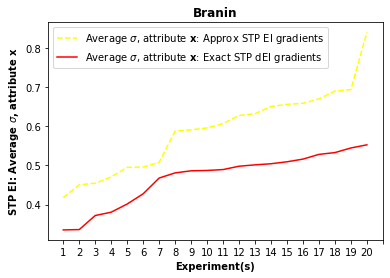

In [121]:
### Visualise!

title = func
plt.figure()

plt.plot(approx_stddev, color = 'Yellow', ls='--', label='Average $\sigma$, attribute $\mathbf{x}$: Approx STP EI gradients')
plt.plot(exact_stddev, color = 'Red', ls='-', label='Average $\sigma$, attribute $\mathbf{x}$: Exact STP dEI gradients')

plt.title(title, weight = 'bold')
plt.xlabel('Experiment(s)', weight = 'bold')
plt.ylabel('STP EI: Average $\sigma$, attribute $\mathbf{x}$', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show() #visualise!
